Some housekeeping genes in the cell are also very highly expressed. Housekeeping genes are genes which are not correlated with specific cell functions but rather are expressed in most/all cells as part of their general maintenance. Such genes can be ribosomal and mitochondrial genes as well as some lncRNAs such as Malat1. However, downstream analysis relies on separating of cell types in terms of their differences and identifying the intrinsic data structure. Therefore such genes can blur the variation between cells and clusters and make dimensionally-reduced representations of the data less-reliable. We remove them from the dataset as they could be both non-informative themselves and confounding.

In [1]:
import scanpy as sc
import glob
from pathlib import Path
import matplotlib.pyplot as plt

Open the filtering diagnostics dicts

In [2]:
file = open('dict_diagn', 'rb')    
dict_cells, dict_genes = pickle.load(file) # load the diagnostic dict 
for keys in dict_genes:  #check if the dictionary was saved properly
    print(keys, '=>', dict_genes[keys])
file.close()

This function makes barplots that show which genes comprise the highest percent of gene counts in the data. It is generally expected for these genes to be ribosomal or lncRNAs, therefore if they are not, that may indicate an underlying problem in the data.

In [1]:
def heg(adata, n_top):
    '''
    Identify and plot highest expressed genes on a sample specific basis with scanpy. Then extract the gene names in a list.

    Args:
        adata (Anndata): Anndata object of a single sample
        n_top (int): number of genes to identify 
        
    Returns:
        list: list of str, highest expressed gene names (as gene symbols)
    '''
    fig, ax = plt.subplots(figsize=(2,3))
    sc.pl.highest_expr_genes(adata, gene_symbols='gene_name', n_top=20, show=False, ax=ax)
    for bar in ax.patches:
        bar.set_edgecolor("none")
        bar.set_linewidth(0)
    plt.title(f'{sample} Highest Expressed Genes', weight='bold')
    plt.ylabel('Gene Name')
    plt.savefig(f'new_data/plots/gene_filtering/high_expr{sample}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # isolate the genes in a list (in this case, gene symbols)
    top_genes = [label.get_text() for label in ax.get_yticklabels()]
    return top_genes

Here we see that some genes comprise 20% or more of total counts. Considering the fact that RNAseq data is highly sparse in general and that biological effects on some genes might be reflected in small changes in RNA abundance, such "overwhelming" counts could have high confounding power.

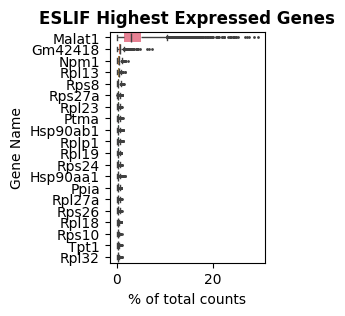

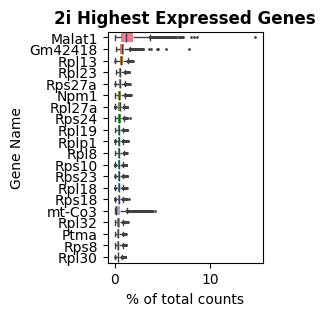

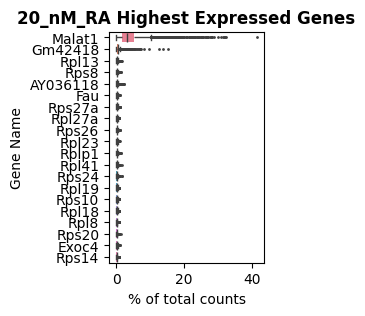

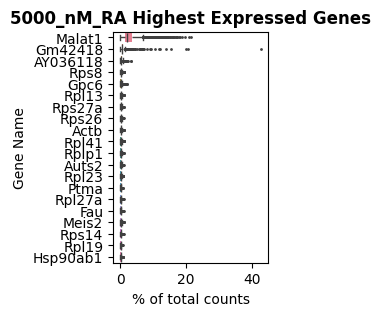

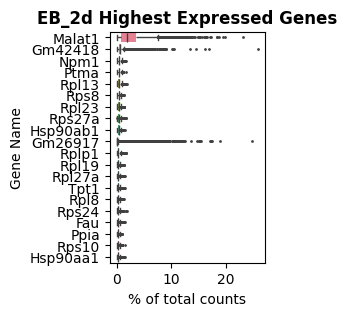

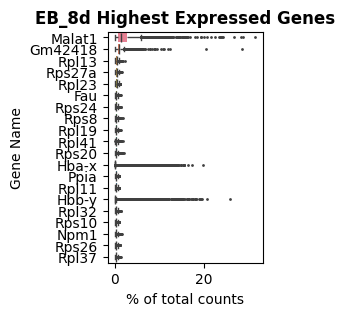

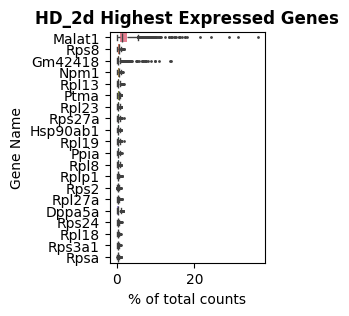

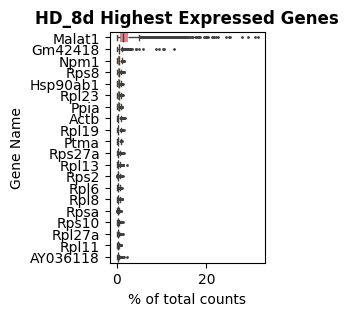

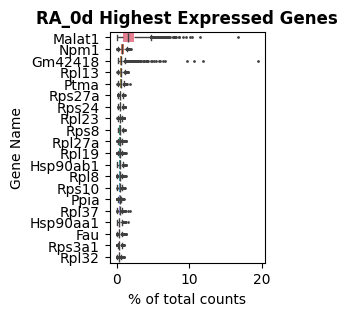

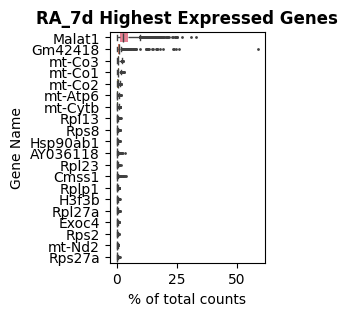

In [3]:
files = glob.glob('new_data/doublet_fil/**/*.*', recursive=True)
for file in files:
    if "h5ad" in file:
        sample = Path(file).parts[2]
        adata = sc.read_h5ad(file)

        #plot genes
        top_genes=plot_heg(adata, 20)

        #diagnostics
        dict_genes[sample].append(20) # 20 genes are filtered out in any case

        # remove the genes after plot inspection
        remaining_genes = [gene for gene in adata.var['gene_name'] if gene not in top_genes]
        mask1 = adata.var['gene_name'].isin(remaining_genes)
        adata = adata[:, mask1]

        #diagnostics
        dict_genes[sample].append(adata.n_vars) # final gene number after all filtering steps
        adata.write_h5ad(f'new_data/gene_filtering/{sample}/gene_filtered_{sample}.h5ad', compression='gzip')

Save the QC data object for diagnostics

In [21]:
try:
    file = open('dict_diagn', 'wb')
    pickle.dump((dict_cells, dict_genes), file)
    file.close()

except:
    print("Something went wrong")

{'ESLIF': [16523, 16503],
 '2i': [15920, 15900],
 '20_nM_RA': [20955, 20935],
 '5000_nM_RA': [19535, 19515],
 'EB_2d': [18417, 18397],
 'EB_8d': [18138, 18118],
 'HD_2d': [15488, 15468],
 'HD_8d': [16648, 16628],
 'RA_0d': [18272, 18252],
 'RA_7d': [19192, 19172]}

References:
see https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_01_qc.html